In [1]:
# 1) Import Libraries
import tensorflow as tf                                 
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2  
from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.callbacks import EarlyStopping  
import matplotlib.pyplot as plt                          
import numpy as np                                       
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  
import seaborn as sns                                     
import pandas as pd  

In [2]:
# 2) Data Preparation & Data Augmentation
IMG_SIZE = (224,224)     
BATCH = 35               

train_gen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input,  
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_ds = train_gen.flow_from_directory(
    r"C:\\Users\\Ahamed\\Downloads\\archive\\Training",  
    target_size=IMG_SIZE,                         
    batch_size=BATCH,                             
    class_mode='categorical',              
    subset='training'                             
)

val_ds = train_gen.flow_from_directory(
    r"C:\\Users\\Ahamed\\Downloads\\archive\\Training", 
    target_size=IMG_SIZE,                          
    batch_size=BATCH,                               
    class_mode='categorical',                  
    subset='validation',                            
)

test_gen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
).flow_from_directory(
    r"C:\\Users\\Ahamed\\Downloads\\archive\\Testing",   
    target_size=IMG_SIZE,                         
    batch_size=BATCH,                             
    class_mode='categorical',                         
    shuffle=False        
)

labels = list(test_gen.class_indices.keys())  
num_classes = len(labels) 

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [3]:
# 3) Build Models
def build_custom_cnn(input_shape=(224,224,3), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_mobilenetv2(num_classes=num_classes):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))  
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [4]:
# 4) Training & Evaluation function
def train_and_evaluate(model, name, optimizer, epochs=20):
    opt_name = type(optimizer).__name__                  
    print(f"\n=== Training {name} with {opt_name} ===")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  

    early_stop = EarlyStopping(
        monitor='val_loss',      
        patience=3,                
        restore_best_weights=True  
    )

    train_steps = train_ds.samples // train_ds.batch_size   
    val_steps = val_ds.samples // val_ds.batch_size         

    history = model.fit(
        train_ds,
        steps_per_epoch=train_steps,       
        validation_data=val_ds,
        validation_steps=val_steps,       
        epochs=epochs,
        callbacks=[early_stop]            
    )

    preds = model.predict(test_gen)                  
    y_pred = np.argmax(preds, axis=1)           
    y_true = test_gen.classes                   

    acc = accuracy_score(y_true, y_pred)     
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)  
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)      
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)           

    print(f"\n=== Classification Report ({name}) ===")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)  
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - {name}")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")         
    plt.plot(history.history['val_accuracy'], label="Val Acc")       
    plt.legend(); plt.title(f"{name} Accuracy Curve")

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")            
    plt.plot(history.history['val_loss'], label="Val Loss")          
    plt.legend(); plt.title(f"{name} Loss Curve")
    plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

In [ ]:
# 5) Run Experiments :
# Custom CNN
results = []

custom_cnn = build_custom_cnn()                          
results.append(train_and_evaluate(custom_cnn, "Custom CNN", optimizers.Adam(0.001)))



=== Training Custom CNN with Adam ===


c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 86s 658ms/step - accuracy: 0.5110 - loss: 1.1268 - val_accuracy: 0.2991 - val_loss: 1.3595
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.5714 - loss: 1.0953

c:\Users\Ahamed\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.5714 - loss: 1.0953 - val_accuracy: 0.3018 - val_loss: 1.3646
Epoch 3/20
 83/130 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.5525 - loss: 1.0228

In [ ]:
# MobileNetV2 with Adam Optimizer
mobilenet_adam = build_mobilenetv2()                     
results.append(train_and_evaluate(mobilenet_adam, "MobileNetV2 (Adam)", optimizers.Adam(0.001)))


=== Training MobileNetV2 (Adam) with Adam ===
Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7156 - loss: 0.8211


=== Training MobileNetV2 (SGD) with SGD ===
Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 87s 644ms/step - accuracy: 0.8113 - loss: 0.5891 - val_accuracy: 0.7821 - val_loss: 0.5360
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - accuracy: 0.8857 - loss: 0.3015

c:\Users\Ahamed\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.8857 - loss: 0.3015 - val_accuracy: 0.7750 - val_loss: 0.5542
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 76s 588ms/step - accuracy: 0.8686 - loss: 0.3542 - val_accuracy: 0.7839 - val_loss: 0.5832
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.8857 - loss: 0.2516 - val_accuracy: 0.7812 - val_loss: 0.5950
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step

=== Classification Report (MobileNetV2 (SGD)) ===
              precision    recall  f1-score   support

      glioma       0.90      0.73      0.80       300
  meningioma       0.67      0.63      0.65       306
     notumor       0.89      0.94      0.91       405
   pituitary       0.82      0.96      0.88       300

    accuracy                           0.82      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.82      0.82      0.82      1311



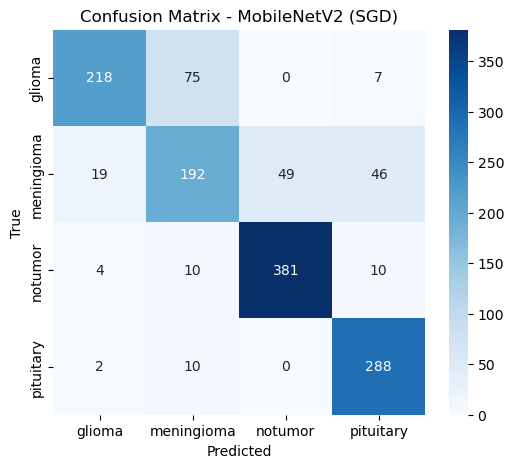

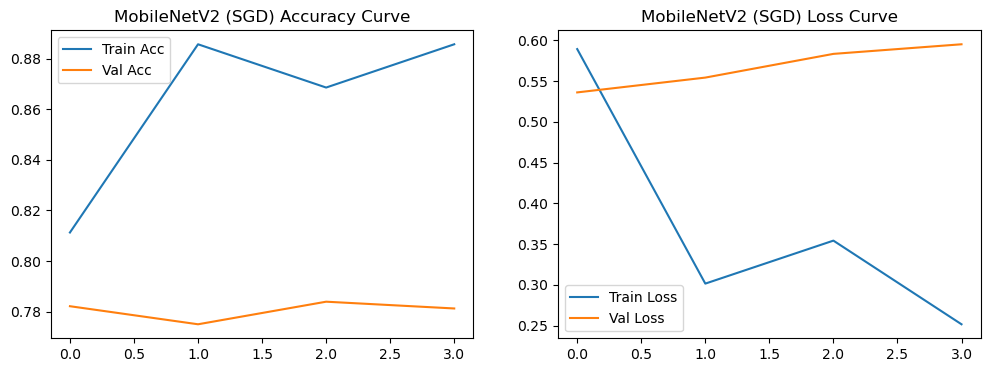

In [ ]:
# MobileNetV2 with SGD Optimizer 
mobilenet_sgd = build_mobilenetv2()                      
results.append(train_and_evaluate(mobilenet_sgd, "MobileNetV2 (SGD)", optimizers.SGD(learning_rate=0.01, momentum=0.9)))

In [ ]:
# 6) Comparison Table
df = pd.DataFrame(results)        
print("\n=== Comparison Table ===")
print(df)

NameError: name 'pd' is not defined